# Compute scattering coefficients

Edited by Louise, 28-02-2023

We show how to compute scattering coefficients. Starting with axisymmetric wavelets.


In [2]:
import s2wav.utils.shapes
from jax import jit, config
config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
import healpy as hp
from matplotlib import pyplot as plt
from importlib import reload

from PIL import Image
from matplotlib.image import pil_to_array

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Scattering_lib as scatlib
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav

import scatcovjax.plotting as plot

In [3]:
reload(plot)
plot.notebook_plot_format()

# Parameters
N = 3 is 5 orientations (2*N-1)

In [172]:
sampling = "mw"
L = 64
multiresolution = True
reality = False
N = 1
J_min = 3
nside = L/2

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(J_max, J)

6 4


# Make a data map

Target = LSS map


Text(0.5, 0, 'l indices')

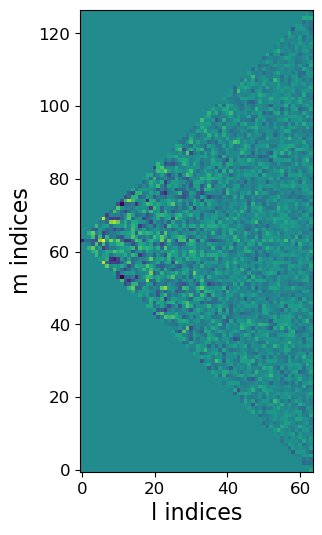

In [173]:
reload(sphlib)
# Random noise
# np.random.seed(2)
# I = np.random.randn(L, 2 * L - 1).astype(np.float64)
# I = np.random.randn(L, 2 * L - 1).astype(np.float64) + 1j*np.random.randn(L, 2 * L - 1).astype(np.float64)
# Ilm = s2fft.forward_jax(I, L, sampling=sampling, nside=nside)


### LSS
I, Ilm = sphlib.make_MW_lensing(L, normalize=True, reality=reality)
print('Target = LSS map')

### PySM
# I, Ilm = sphlib.make_pysm_sky(L, 'cmb', sampling=sampling, nest=False, normalize=True, reality=reality)
# print('Target = CMB map')

### Planet image
# I, Ilm = sphlib.make_planet(L, 'venus', normalize=True, reality=reality)
# print('Target = Planet map', '(Ntheta, Nphi)=', I.shape)
# print('Ilm', Ilm.shape)


# Plot the map
# plt.figure(figsize=(8, 6))
# plt.imshow(I)
# hp.mollview(I)

plt.figure(figsize=(8, 6))
plt.imshow(np.real(Ilm.T), origin='lower')
plt.ylabel('m indices')
plt.xlabel('l indices')




# Build the wavelets

(7, 64, 127)


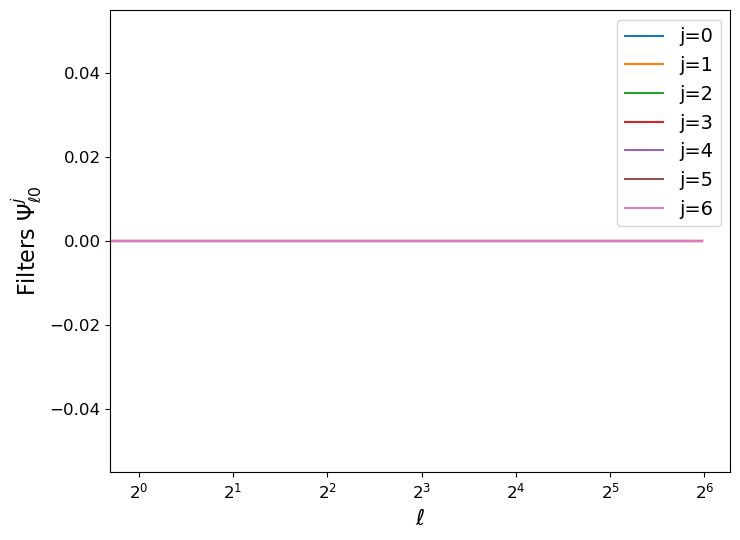

In [174]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=False, m=L-2)


filters = filters[0]
print(filters.shape)

# Compute the scattering coefficients

In [175]:
reload(scatlib)
mean, var, S1, P00, C01, C11 = scatlib.scat_cov_dir(
    Ilm, L, N, J_min, sampling, nside, reality, multiresolution, filters=filters, normalisation=None)


 j2=3 Lj2=16

 j2=4 Lj2=32

 j2=5 Lj2=64

 j2=6 Lj2=64


In [176]:
print(C01, len(C01))

[Array([[[-0.00487589]],

       [[-0.00038859]],

       [[ 0.00074214]]], dtype=float64), Array([[[-0.00089273]],

       [[ 0.00163064]]], dtype=float64), Array([[[-0.003628]]], dtype=float64)] 3


In [129]:
import jax.lax as lax

precomps = s2wav.transforms.jax_wavelets.generate_wigner_precomputes(L, N, J_min, 2.0, sampling, None, False,
                                                                     reality, multiresolution)

W = s2wav.flm_to_analysis(
        Ilm,
        L,
        N,
        J_min,
        sampling=sampling,
        nside=nside,
        reality=reality,
        multiresolution=multiresolution,
        filters=filters,
        precomps=None
    )  # [J2][Norient2, Nthetaj2, Nphij2]=[J][2N-1, Lj, 2Lj-1]
print('W', len(W), W[0].shape, W[-1].shape)


Njjprime = []
for j2 in range(J_min, J_max + 1):
    # Subsampling: the resolution in the plane (l, m) is adapted at each scale j2
    Lj2 = s2wav.utils.shapes.wav_j_bandlimit(L, j2, 2.0, multiresolution)  # Band limit at resolution j2
    print(f'\n {j2=} {Lj2=}')

    def modulus_step_for_j(n, args):
        """
        Compute M_lm = |W|_lm for one orientation.
        This function is re-defined at each step j2.
        """
        M_lm = args
        M_lm = M_lm.at[n].add(
            s2fft.forward_jax(
                jnp.abs(W[j2 - J_min][n]),
                Lj2,
                0,
                sampling=sampling,
                nside=nside,
                reality=reality,
            )
        )
        return M_lm  # [Lj2, Mj2] = [Lj2, 2Lj2-1]

    ### Compute M_lm for all orientations
    # Initialization
    M_lm_j2 = jnp.zeros((2 * N - 1, Lj2, 2 * Lj2 - 1), dtype=jnp.complex128)  # [Norient2, Lj2, Mj2]
    # Loop on orientations
    M_lm_j2 = lax.fori_loop(0, 2 * N - 1, modulus_step_for_j, M_lm_j2)  # [Norient2, Lj2, Mj2]


    if j2 != J_min:
        ### Filters
        # We must pass all scales (selection between J_min and J_max=j2-1 done in the function
        filters_j2 = filters[:, :Lj2, L - Lj2: L - 1 + Lj2]
        print(np.arange(J_min, j2))
        ### Compute Njjprime
        Njjprime_for_j2 = []
        for n in range(2*N-1):
            # Wavelet transform of Mlm: Nj1j2 = M_j2 * Psi_j1
            # val shape is [J1j][Norient1, Nthetaj1, Nphij1]
            # Not sure of the len of val (some terms are 0)
            val = s2wav.flm_to_analysis(
                M_lm_j2[n],
                Lj2,
                N,
                J_min=J_min,
                J_max=j2-1,  # Only do convolutions at larger scales: from J_min to j2-1
                sampling=sampling,
                nside=nside,
                reality=reality,
                multiresolution=multiresolution,
                filters=filters_j2,
                precomps=precomps[:(j2-1)-J_min+1]  # precomps are ordered from J_min to J_max
            )
            print(len(val))
            print(val[1][0, :3, 0])
            Njjprime_for_j2.append(val)  # [Norient2][J1j][Norient1, Nthetaj1, Nphij1]
        Njjprime.append(Njjprime_for_j2)  # [J2-1][Norient2][J1j][Norient1, Nthetaj, Nphij] (M_j2 * Psi_j1)

W 5 (1, 8, 15) (1, 64, 127)

 j2=2 Lj2=8

 j2=3 Lj2=16
[2]
3
[0.+0.j 0.+0.j 0.+0.j]

 j2=4 Lj2=32
[2 3]
4
[-0.00493139+9.29578303e-19j -0.03291455-9.99574209e-18j
 -0.01607305-6.78515134e-18j]

 j2=5 Lj2=64
[2 3 4]
5
[-0.00713333-1.33350753e-18j -0.00762142+7.35193750e-18j
  0.00820712+1.92655209e-17j]

 j2=6 Lj2=64
[2 3 4 5]
5
[ 0.0056911 -3.20046505e-18j  0.00079057+8.20620033e-18j
 -0.00582805+9.92475711e-18j]


(1, 64, 127)


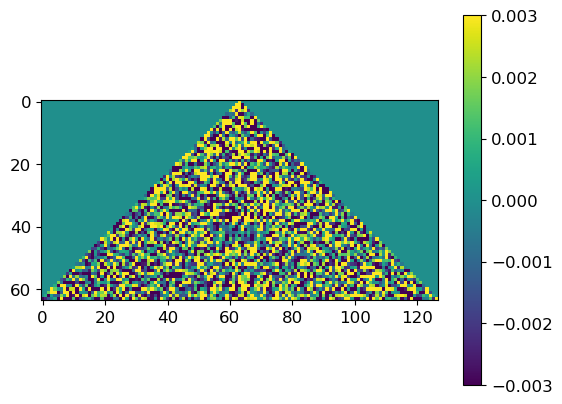

In [162]:
print(M_lm_j2.shape)
plt.imshow(np.real(M_lm_j2[0]), vmin=-0.003, vmax=0.003)
plt.colorbar()

5
(1, 16, 31)


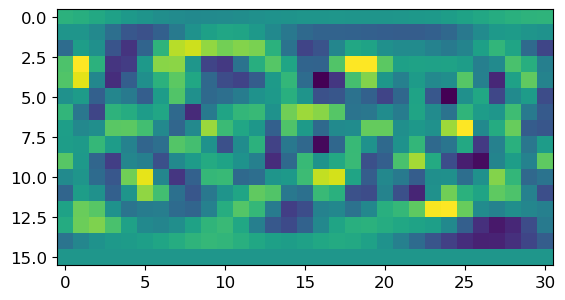

In [131]:
print(len(val))
print(val[1].shape)
plt.imshow(np.real(val[1][0, :, :]), vmin=-0.02, vmax=0.02)

In [132]:
### Reorder and flatten Njjprime, convert to JAX arrays for C01/C11
Njjprime_flat = []
# For C01 and C11, we need j1 < j2 so j1=Jmax is not possible, this is why j1 goes from J_min to J_max-1.
for j1 in range(J_min, J_max):  # J_min <= j1 <= J_max-1
    Njjprime_flat_for_j2 = []
    for j2 in range(j1 + 1, J_max + 1):  # j1+1 <= j2 <= J_max
        Njjprime_flat_for_n2 = []
        for n2 in range(2 * N - 1):
            Njjprime_flat_for_n2.append(Njjprime[j2 - J_min - 1][n2][j1 - J_min][:, :, :])  # [Norient2][Norient1, Nthetaj1, Nphij1]
        Njjprime_flat_for_j2.append(Njjprime_flat_for_n2)  # [J2][Norient2][Norient1, Ntheta_j1, Nphi_j1]
    # [J1][J2, Norient2, Norient1, Nthetaj1, Nphij1] => [J-1][Jj2, Norient, Norient, Ntheta_j1, Nphi_j1]
    Njjprime_flat.append(jnp.array(Njjprime_flat_for_j2))
print(Njjprime_flat[3-J_min])


[[[[[-4.93139172e-03+9.29578303e-19j -2.37805688e-03+8.40397037e-19j
      1.01252565e-03+8.16065658e-19j ...
     -8.29227139e-03+1.42516486e-18j -7.68120083e-03+1.25501530e-18j
     -6.63893846e-03+1.07698118e-18j]
    [-3.29145495e-02-9.99574209e-18j -3.74776812e-02-9.48397144e-18j
     -2.87070337e-02-6.79245702e-18j ...
     -4.49783653e-03-3.71447441e-18j -9.64414155e-03-5.92716864e-18j
     -2.10067107e-02-8.43116107e-18j]
    [-1.60730493e-02-6.78515134e-18j -4.41622473e-02-6.90907365e-18j
     -5.24219328e-02-1.33446716e-18j ...
      1.71614098e-02+1.04534579e-17j  2.26333513e-02+7.27692038e-18j
      1.17773263e-02-2.09034292e-19j]
    ...
    [ 1.29131481e-03-3.46607944e-18j  1.67320241e-03-2.91764849e-18j
      9.74444121e-04-2.04883864e-18j ...
      1.71269019e-02+7.50632400e-18j  9.21036669e-03+1.52566655e-18j
      3.07778467e-03-2.40568406e-18j]
    [-1.10830192e-02-1.76632060e-18j -6.74306502e-03-1.29089452e-18j
     -2.31730394e-03-3.86444812e-19j ...
     -2.216771

In [153]:
J_max

6

In [135]:
print(S1)
print(P00)
print(C01)
print(C11)

[Array([0.04806283], dtype=float64), Array([0.11017925], dtype=float64), Array([0.15126785], dtype=float64), Array([0.19884347], dtype=float64), Array([0.14975468], dtype=float64)]
[Array([0.00402205], dtype=float64), Array([0.01920104], dtype=float64), Array([0.03635014], dtype=float64), Array([0.0615912], dtype=float64), Array([0.03546246], dtype=float64)]
[Array([[[-0.00145925]],

       [[-0.00109151]],

       [[ 0.00045574]],

       [[ 0.00077139]]], dtype=float64), Array([[[-0.00487589]],

       [[-0.00038859]],

       [[ 0.00074214]]], dtype=float64), Array([[[-0.00089273]],

       [[ 0.00163064]]], dtype=float64), Array([[[-0.003628]]], dtype=float64)]
[Array([[[[[ 1.13284188e-03]]],


        [[[ 1.41687797e-04]]],


        [[[ 4.72980895e-05]]],


        [[[-1.41006442e-05]]]],



       [[[[ 1.41687797e-04]]],


        [[[ 8.78808778e-04]]],


        [[[ 1.77896572e-04]]],


        [[[ 9.14025477e-05]]]],



       [[[[ 4.72980895e-05]]],


        [[[ 1.77896572e-

# Plot S1 et P00

In [177]:
S1 = np.reshape(S1, [J, 2*N-1])
P00 = np.reshape(P00, [J, 2*N-1])
print(S1)
print(P00)

[[0.11017925]
 [0.15126785]
 [0.19884347]
 [0.14975468]]
[[0.01920104]
 [0.03635014]
 [0.0615912 ]
 [0.03546246]]


In [178]:
def plot_S1_P00(coeff, ylabel, figsize=(12,6)):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)

    for j in range(J):
        ax0.plot(coeff[j, :], label=f'{j=}')
    ax0.set_xlabel('n')
    ax0.set_ylabel(ylabel)
    ax0.legend()

    for n in range(2*N-1):
        ax1.plot(coeff[:, n], label=f'{n=}')
    ax1.set_xlabel('j')
    ax1.set_ylabel(ylabel)
    ax1.legend()

    fig.tight_layout()
    return fig


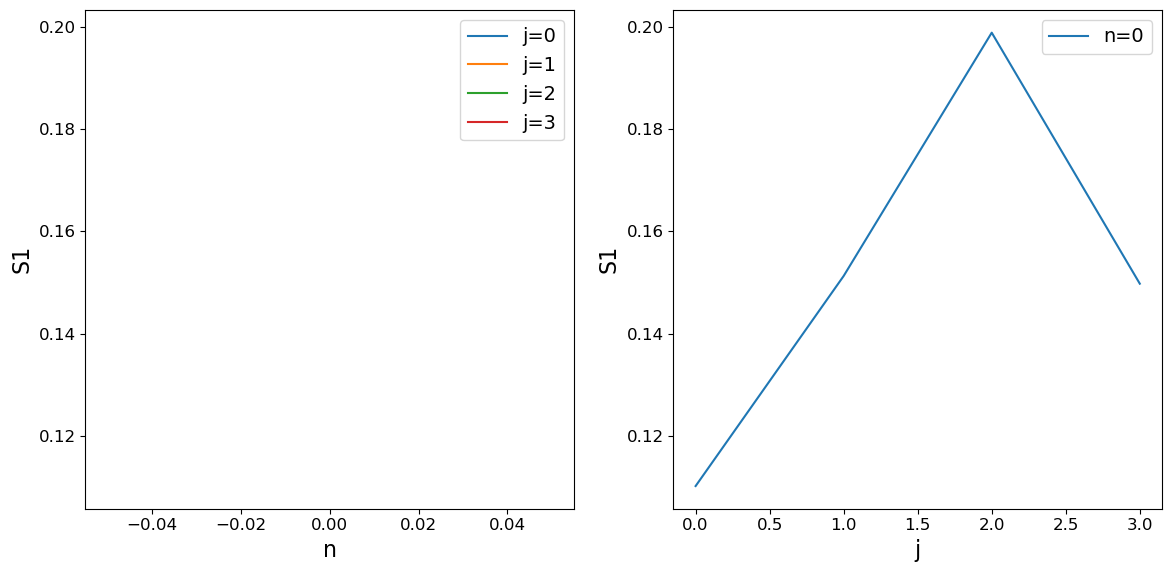

In [179]:
fig = plot_S1_P00(S1, ylabel='S1')

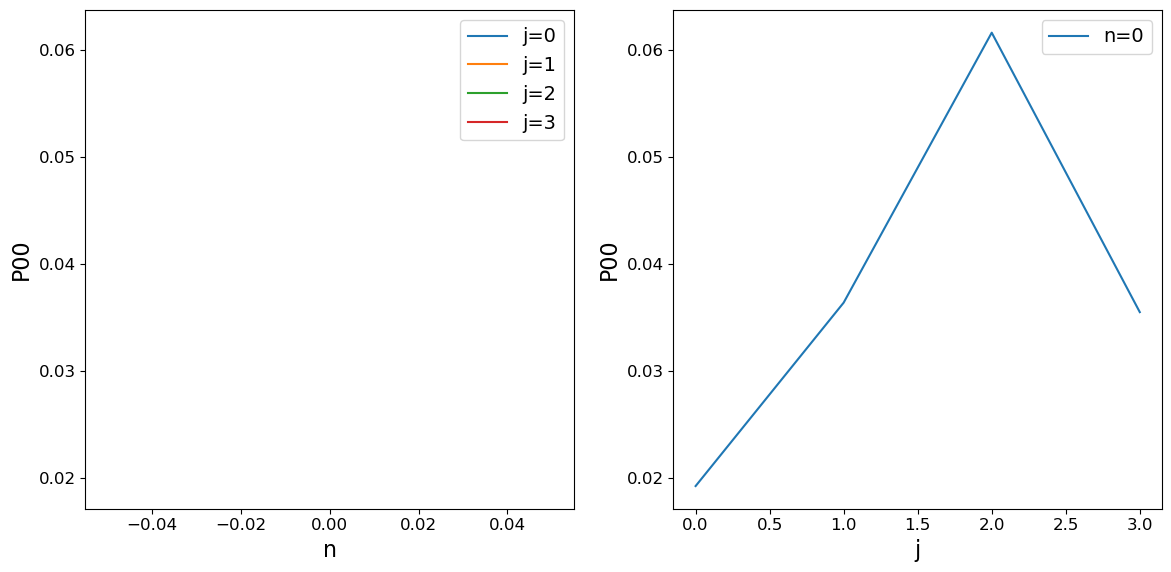

In [180]:
fig = plot_S1_P00(P00, ylabel='P00')

In [181]:
# Average over orientations
avgS1 = np.average(S1.reshape(-1, 2*N-1), axis=1)
avgP00 = np.average(P00.reshape(-1, 2*N-1), axis=1)


# Plot C01

In [182]:
print(len(C01))
print(C01)

3
[Array([[[-0.00487589]],

       [[-0.00038859]],

       [[ 0.00074214]]], dtype=float64), Array([[[-0.00089273]],

       [[ 0.00163064]]], dtype=float64), Array([[[-0.003628]]], dtype=float64)]


In [183]:
jnp.min(jnp.abs(jnp.concatenate(C01)))

Array(0.00038859, dtype=float64)

In [184]:
color_list = [ 'c', 'b', 'r', 'g', 'orange', 'm']

3
[4 5 6]
(3, 1, 1)
4
[5 6]
(2, 1, 1)
5
[6]
(1, 1, 1)


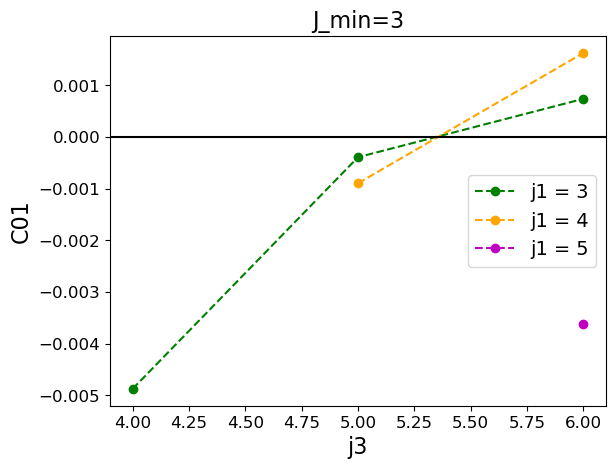

In [185]:
plt.figure()
for j1 in range(J_min, J_max):
    
    # Determine the j3 values j1 < j3
    print(j1)
    
    allj3 = np.arange(j1+1, J_max+1)
    print(allj3)
    for n3 in range(2*N-1):
        for n1 in range(1):
            plt.plot(allj3 , C01[j1-J_min][:, n3, n1], 'o--', color=color_list[j1], label=f'j1 = {j1}')
    print(C01[j1-J_min].shape)
plt.xlabel('j3')
plt.ylabel('C01')
plt.axhline(0, color='k')
plt.title(f'{J_min=}')
plt.legend()

In [111]:
# plot.plot_scatcov_coeffs(np.log2(avgS1), 
#                          np.log2(avgP00), 
#                          C01, 
#                          C11, name='Avg', hold=True, color='k', ls='-')

# colorlist = ['b', 'g', 'r', 'orange', 'm']
# for n in range(2*N-1):
#     # Select one orientation
#     S1_one_orient = S1[np.where(idxS1_P00[1, :] == n)[0]]
#     P00_one_orient = P00[np.where(idxS1_P00[1, :] == n)[0]]
    
#     plot.plot_scatcov_coeffs(np.log2(S1_one_orient), 
#                              np.log2(P00_one_orient), 
#                              C01, 
#                              C11, name=f'{n=}', hold=False, color=colorlist[n], ls='', marker='o')

1 [2 3 4]
2 [3 4]
3 [4]


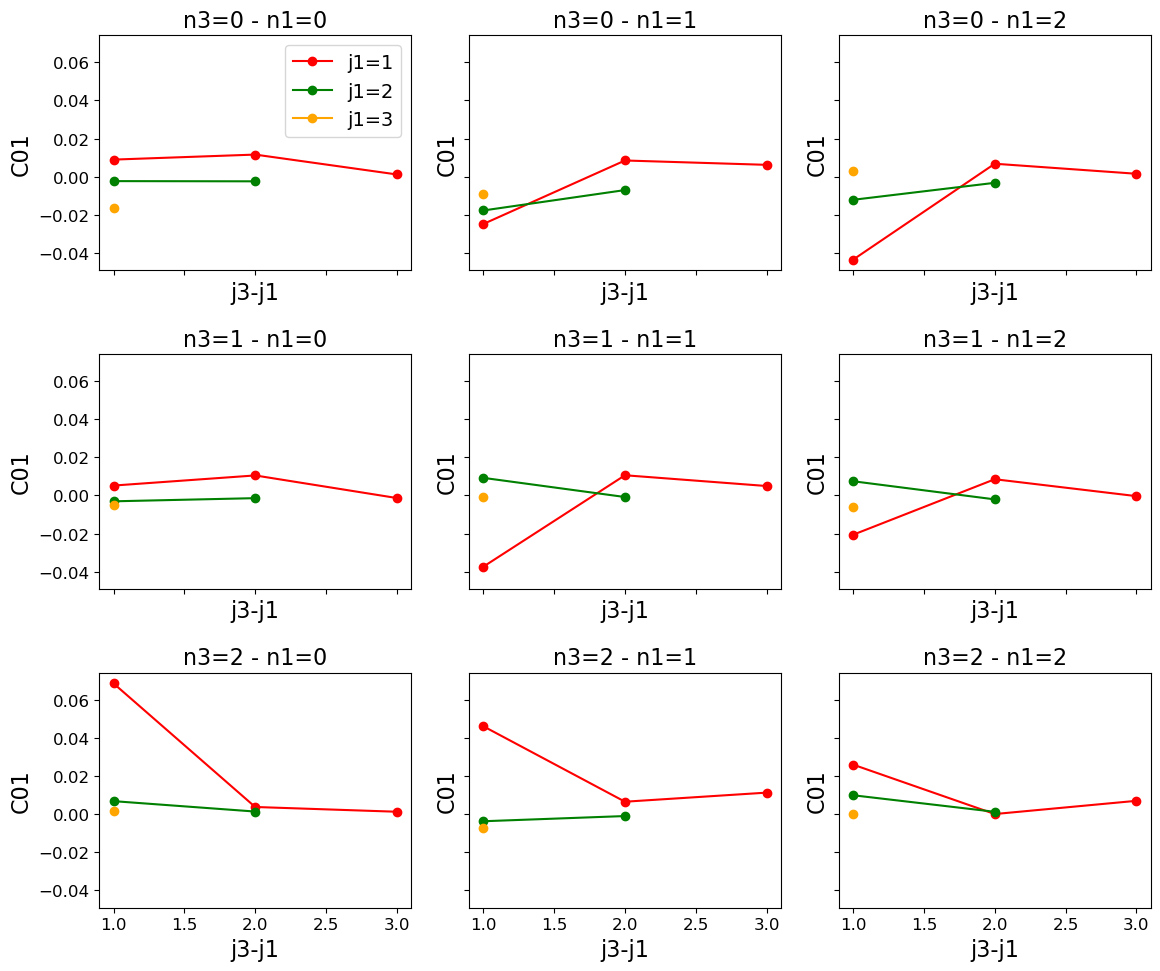

In [31]:
print(C01)

0 [1 2 3 4] 1
1 [2 3 4] 2
2 [3 4] 3
3 [4] 4


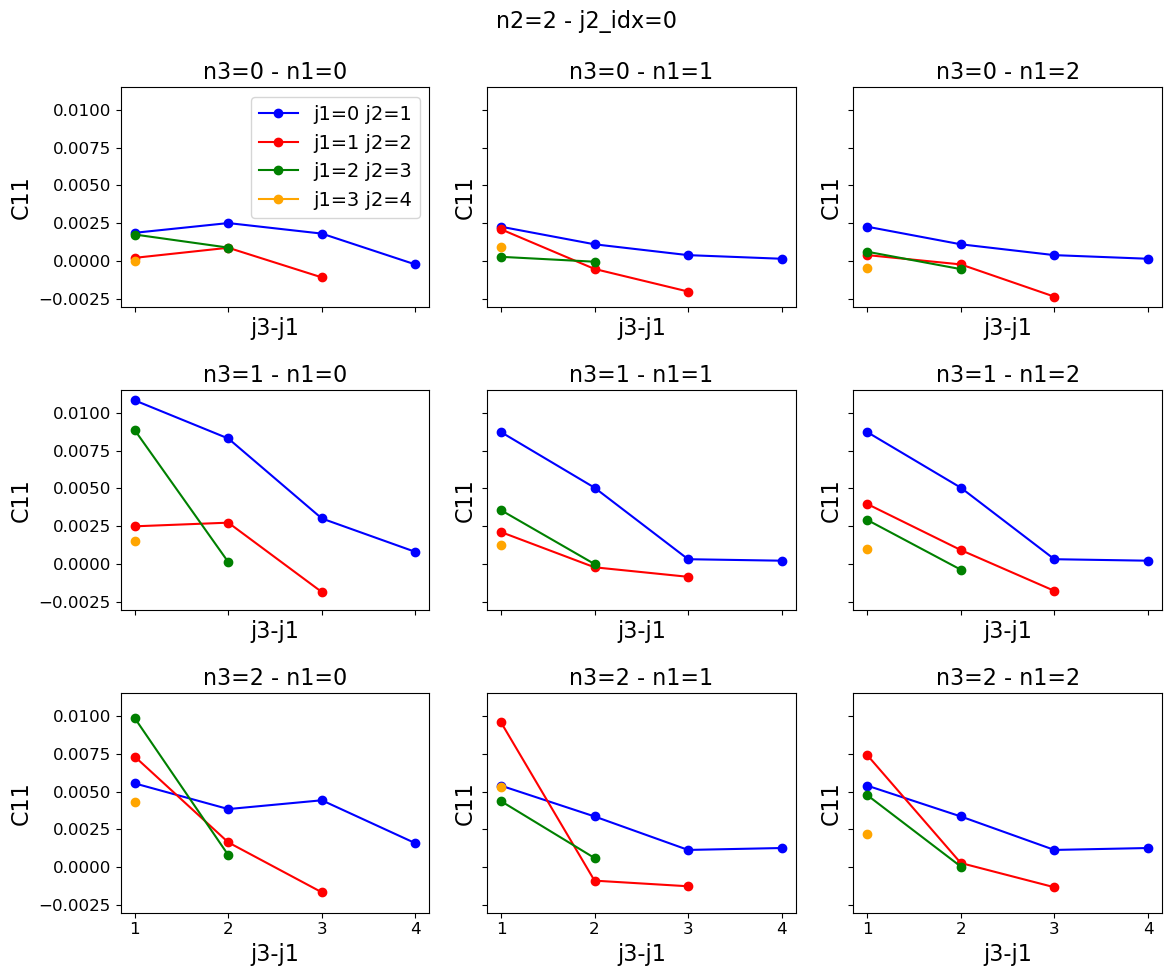

In [122]:
print(C11)

# Check on white noise

1 [2 3 4] 2
2 [3 4] 3
3 [4] 4


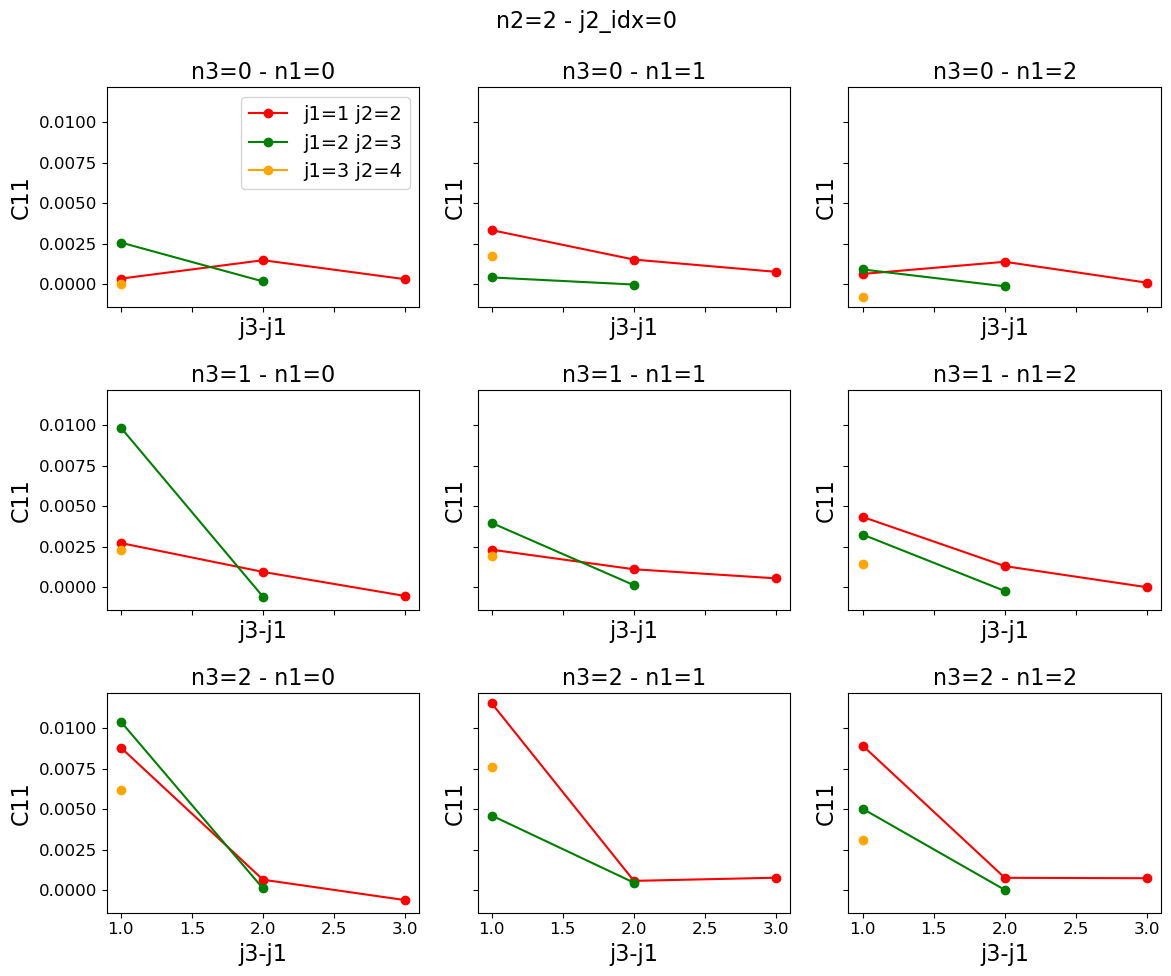

In [33]:
# Check that C01 is compatible with 0 for white noise
nreals = 30
S1_all, P00_all, C01_all, C11_all = [], [], [], []
for i in range(nreals):
    print('real:', i)
    I = np.random.randn(L, 2 * L - 1).astype(np.float64) + 1j*np.random.randn(L, 2 * L - 1).astype(np.float64)
    Ilm = s2fft.forward_jax(I, L, sampling=sampling, nside=nside)

    mean, var, S1, P00, C01, C11 = scatlib.scat_cov_dir(
        Ilm, L, N, J_min, sampling, nside, reality, multiresolution, filters=filters)

    print(C01)
    print(C11)
    S1_all.append(S1)
    P00_all.append(P00)
    C01_all.append(C01)
    C11_all.append(C11)

S1_all = np.array(S1_all)
P00_all = np.array(P00_all)
C01_all = np.array(C01_all)
C11_all = np.array(C11_all)

In [124]:
# Normalize by the STD over realisations
stdS1 = np.std(S1_all, axis=0)
stdP00 = np.std(P00_all, axis=0)
stdC01 = np.std(C01_all, axis=0)
stdC11 = np.std(C11_all, axis=0)

avgS1 = np.mean(S1_all, axis=0)
avgP00 = np.mean(P00_all, axis=0)
avgC01 = np.mean(C01_all, axis=0)
avgC11 = np.mean(C11_all, axis=0)

TypeError: loop of ufunc does not support argument 0 of type Array which has no callable sqrt method

In [125]:
stdC11.shape


NameError: name 'stdC11' is not defined

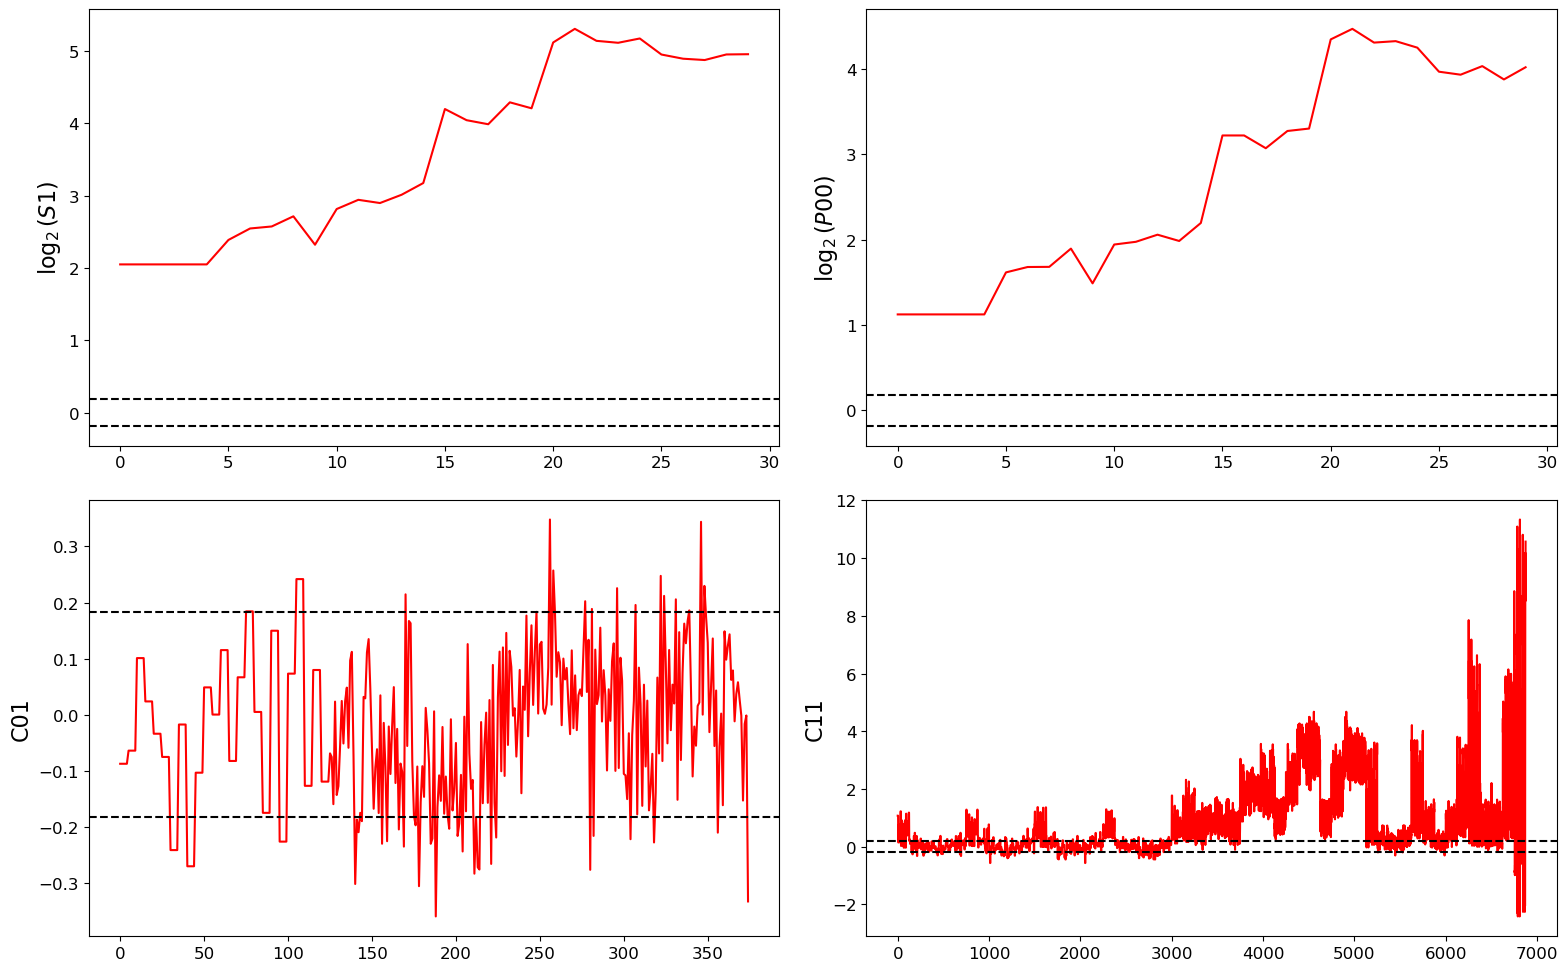

In [15]:
def forplot(ax):
    # ax.legend(fontsize=16)
    ax.axhline(-1/np.sqrt(nreals), color='k', ls='--')
    ax.axhline(1/np.sqrt(nreals), color='k', ls='--')
    return

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].plot(np.log2(avgS1 / stdS1), 'r')
axs[0].set_ylabel(r'$\log_2(S1)$', fontsize=16)
#forplot(axs[0])

axs[1].plot(np.log2(avgP00 / stdP00), 'r')
axs[1].set_ylabel(r'$\log_2(P00)$', fontsize=16)
#forplot(axs[1])

axs[2].plot(avgC01/stdC01, 'r')
axs[2].set_ylabel('C01', fontsize=16)
forplot(axs[2])
# axs[2].set_yscale('log')

axs[3].plot(avgC11/stdC11, 'r')
axs[3].set_ylabel('C11', fontsize=16)
forplot(axs[3])
# axs[3].set_yscale('log')

fig.tight_layout()

In [144]:
print(C11[:])

[-9.15744707e-05+8.83892392e-21j -9.15744707e-05+8.83892392e-21j
 -9.15744707e-05+8.83892392e-21j ...  1.46944530e-04-4.27005649e-13j
  2.08786748e-03+1.39721531e-11j -5.98486284e-05-7.50424319e-12j]
